# Protein-rimter

In [1]:
import sys
import os
from PIL import Image
import torch
from torchvision import models
import torch.nn as nn
import pickle
from matplotlib import pyplot as plt
import pandas as pd

# Add the directory containing module (absolute path)
src_dir = "/home/evanz/protein-rimeter"
sys.path.append(os.path.abspath(f"{src_dir}/src"))
from data.make_dataset import prep_data
from models.train_model import train_model
from models.model_predict import predict_model_single_image

Parameter Setup

In [2]:
data_dir = f'{src_dir}/data/raw/food-101/images'
split_file_train = f'{src_dir}/data/raw/food-101/meta/train.txt'
split_file_test = f'{src_dir}/data/raw/food-101/meta/test.txt'
model_dir = f'{src_dir}/models'

classes_file = f'{src_dir}/data/raw/food-101/meta/protein.txt'
with open(classes_file, "r") as file:
    classes = file.read().splitlines()


batch_size = 32
num_epochs = 10
learning_rate = 0.001


Prepare Dataset

In [3]:
train_loader, val_loader = prep_data(data_dir, split_file_train, classes, batch_size)
test_loader = prep_data(data_dir, split_file_test, classes, batch_size)

Train Model

In [4]:
model = train_model(train_loader, val_loader, model_dir, num_epochs, learning_rate)
torch.save(model.state_dict(), f'{model_dir}/resnet.pth')

/home/evanz/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/evanz/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
train Loss: 1.2204 Acc: 0.5717
val Loss: 0.6773 Acc: 0.7610
Epoch 1/9
train Loss: 0.5451 Acc: 0.8169
val Loss: 0.5679 Acc: 0.7943
Epoch 2/9
train Loss: 0.2800 Acc: 0.9138
val Loss: 0.5469 Acc: 0.8076
Epoch 3/9
train Loss: 0.1287 Acc: 0.9702
val Loss: 0.5450 Acc: 0.8171
Epoch 4/9
train Loss: 0.0596 Acc: 0.9907
val Loss: 0.5600 Acc: 0.8200
Epoch 5/9
train Loss: 0.0370 Acc: 0.9957
val Loss: 0.5882 Acc: 0.8124
Epoch 6/9
train Loss: 0.0216 Acc: 0.9988
val Loss: 0.6279 Acc: 0.8181
Epoch 7/9
train Loss: 0.0191 Acc: 0.9981
val Loss: 0.6157 Acc: 0.8200
Epoch 8/9
train Loss: 0.0147 Acc: 0.9986
val Loss: 0.6156 Acc: 0.8162
Epoch 9/9
train Loss: 0.0131 Acc: 0.9979
val Loss: 0.6156 Acc: 0.8267


Test Model

In [12]:
# Load trained model
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(classes)) 
model.load_state_dict(torch.load(f'{model_dir}/resnet_2.pth'))
model.eval()  # set the model to evaluation mode

# Load label encoder
with open('../models/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

image_path = f'{data_dir}/fish_and_chips/100703.jpg'
predicted_class = predict_model_single_image(model, image_path, label_encoder)

print(f"Prediction: {predicted_class}")

/home/evanz/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/evanz/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Prediction: ['hamburger']


Nutrional Information

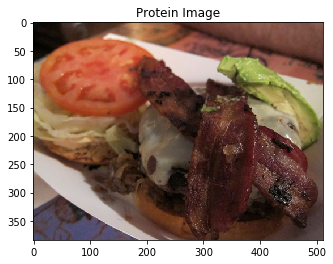

Food: Hamburger
Protein Content: 14.0 (g/100g)
Additional: 20/burger


In [13]:
img = Image.open(image_path).convert('RGB')
plt.imshow(img)
plt.title("Protein Image")
plt.show()

nutritional_file = f'{src_dir}/data/raw/food-101/meta/nutritional.csv'
nutrition_df = pd.read_csv(nutritional_file)
food_info = nutrition_df[nutrition_df['class_label'] == predicted_class[0]]
print(f"Food: {food_info['name'].values[0]}")
print(f"Protein Content: {food_info['protein'].values[0]} (g/100g)")

if not(pd.isna(food_info['additional'].values[0])): 
    print(f"Additional: {food_info['additional'].values[0]}")